# Module 1 Load Data

In [1]:
import sys
from collections import defaultdict
import numpy as np
import pandas as pd
import tensorflow as tf

## load table 

In [2]:
## load dataset & filter out missing data
# dbfile = pd.read_csv('./Data/vdjdb.slim.txt', sep='\t')
dbfile = pd.read_csv('./Data/VDJDB/vdjdb_full.txt', sep='\t')
# print(dbfile.columns)
dbfile = dbfile[['cdr3.alpha', 'cdr3.beta','antigen.epitope','antigen.species',"mhc.class"]]
print(dbfile.shape)
dbfile = dbfile.dropna(subset=['cdr3.alpha', 'cdr3.beta','antigen.epitope'])
print(dbfile.shape)
dbfile.head()

(60055, 5)
(29266, 5)


C:\Users\croco\AppData\Local\Temp\ipykernel_15660\3075150544.py:3: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  dbfile = pd.read_csv('./Data/VDJDB/vdjdb_full.txt', sep='\t')


,cdr3.alpha,cdr3.beta,antigen.epitope,antigen.species,mhc.class
0,CIVRAPGRADMRF,CASSYLPGQGDHYSNQPQHF,FLKEKGGL,HIV-1,MHCI
2,CAVPSGAGSYQLTF,CASSFEPGQGFYSNQPQHF,FLKEKGGL,HIV-1,MHCI
3,CAVKASGSRLT,CASSYEPGQVSHYSNQPQHF,FLKEKGGL,HIV-1,MHCI
4,CAYRPPGTYKYIF,CASSALASLNEQFF,FLKEKGGL,HIV-1,MHCI
5,CIVRAPGRADMRF,CASSYLPGQGDHYSNQPQHF,FLKEQGGL,HIV-1,MHCI


In [3]:
iedbfile = pd.read_csv('./Data/IEDB/tcell_receptor_table_export_1668026760.csv')
# print(iedbfile.columns)
# Chain 1 Full Sequence', 'Chain 1 Accession', 'Chain 1 CDR3 Curated',
#        'Chain 1 CDR3 Calculated'
iedbfile = iedbfile[['Chain 1 CDR3 Curated','Chain 2 CDR3 Curated',"Description","Organism"]]
print(iedbfile.shape)
iedbfile = iedbfile.dropna(subset=['Chain 1 CDR3 Curated','Chain 2 CDR3 Curated',"Description"])
iedbfile.Description = iedbfile.Description.str.split(' ').str[0]
iedbfile = iedbfile[~iedbfile.Description.str.contains('[^ARNDCQEGHILKMFPSTWYV]',na=False)]
print(iedbfile.shape)
iedbfile.head()

C:\Users\croco\AppData\Local\Temp\ipykernel_15660\605436328.py:1: DtypeWarning: Columns (8,10,11,13,15,16,17,18,19,20,21,22,23,24,25,30,31,36,37,42,44,45,46,47,48,49,50,51,52,53,54,59,60,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  iedbfile = pd.read_csv('./Data/IEDB/tcell_receptor_table_export_1668026760.csv')


(205824, 4)
(25927, 4)


,Chain 1 CDR3 Curated,Chain 2 CDR3 Curated,Description,Organism
0,IVVRSSNTGKLI,ASSQDRDTQY,VMAPRTLIL,Homo sapiens (human)
80,CAVTTDSWGKLQF,CASRPGLAGGRPEQYF,LLFGYPVYV,Human T-cell leukemia virus type I (Human T ce...
82,CAVTTDSWGKLQF,CASRPGLMSAQPEQYF,LLFGYPVYV,Human T-cell leukemia virus type I (Human T ce...
109,CAVRPTSGGSYIPTF,CASSYVGNTGELFF,SLLMWITQC,Homo sapiens (human)
202,TVYGGATNKLI,SARGGSYNSPLH,LSRFSWGAEGQRPGFGYGG,Homo sapiens (human)


In [4]:
# mixeddb = 

In [5]:
# print(len(train['antigen.epitope']))
# print(sum(train['antigen.epitope']=="GILGFVFTL"))
# for i in set(train['antigen.epitope']):
#     train['antigen.epitope'].count(i)
dbfile = dbfile.drop_duplicates(subset=['cdr3.alpha', 'cdr3.beta','antigen.epitope'])
dbfile = dbfile.drop(dbfile.query('`antigen.epitope` == "KLGGALQAK"').sample(frac=.87).index)

## Encoding & split sets

In [6]:
from functions import load
# from functions.load import enc_list_bl_max_len, positional_coding, blosum50_20aa 

In [7]:
from importlib import reload
reload(load)

<module 'functions.load' from 'c:\\Users\\croco\\OneDrive - Emory University\\Courses\\BMI 536 Deep Learning\\FinalProj\\functions\\load.py'>

In [8]:
print(dbfile.head(n=2)["cdr3.alpha"])
load.enc_list_bl_max_len(dbfile.head(n=2)["cdr3.alpha"],32).shape

0     CIVRAPGRADMRF
2    CAVPSGAGSYQLTF
Name: cdr3.alpha, dtype: object


(2, 32, 20)

In [9]:
tokens = load.blosum50_20aa.keys()

tokens = list(tokens)
tokens.insert(0, '.')
tokens.insert(1, '>')
tokens.insert(2, '<')
tk_dict = defaultdict(lambda: None)
for idx in range(len(tokens)):
    tk_dict[tokens[idx]]=idx
vocabSize=23

In [10]:
load.positional_coding(dbfile.head(n=52)["cdr3.alpha"],tk_dict,30).shape
load.positional_coding(iedbfile.head(n=52)["Chain 1 CDR3 Curated"],tk_dict,30).shape

(52, 30)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
train, test = train_test_split(dbfile[dbfile['antigen.epitope'].str.len()<=12], shuffle=True ,test_size=0.2)

In [13]:
np.concatenate(load.positional_coding(("CIVRAPGRADMRF","CASSYLPGQGDHYSNQPQHF"), tk_dict, 30)) #CIVRAPGRADMRF	CASSYLPGQGDHYSNQPQHF	FLKEKGGL	

array([ 1.,  7., 12., 22.,  4.,  3., 17., 10.,  4.,  3.,  6., 15.,  4.,
       16.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  7.,  3., 18., 18., 21., 13., 17., 10.,
        8., 10.,  6., 11., 21., 18.,  5.,  8., 17.,  8., 11., 16.,  2.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

## to datasets

In [14]:
dbfile['antigen.epitope'].value_counts()

GILGFVFTL     1900
KLGGALQAK     1812
AVFDRKSDAK    1757
RAKFKQLL      1216
IVTDFSVIK      718
              ... 
MLFSHGLVK        1
EMLFSHGLVK       1
TLREIRRYQK       1
WSYDSTLLAY       1
YYTSNPTTF        1
Name: antigen.epitope, Length: 949, dtype: int64

In [42]:
ept_train = load.ept_coding(train['antigen.epitope'], tk_dict, 13,train=True)
tcra_train = load.positional_coding(train["cdr3.alpha"], tk_dict, 32)
tcrb_train = load.positional_coding(train["cdr3.beta"], tk_dict, 32)
# ept_train = np.roll(ept_train, 1)
ept_train_lb = load.ept_coding(train['antigen.epitope'], tk_dict, 13,label=True)
tcr_train = np.concatenate((tcra_train,tcrb_train),axis=1)
print(ept_train.shape, tcra_train.shape, tcrb_train.shape,tcr_train.shape)
ept_test = load.ept_coding(test['antigen.epitope'], tk_dict, 13,train=True)
tcra_test = load.positional_coding(test["cdr3.alpha"], tk_dict, 32)
tcrb_test = load.positional_coding(test["cdr3.beta"], tk_dict, 32)
tcr_test = np.concatenate((tcra_test,tcrb_test),axis=1)
# ept_train = np.roll(ept_train, 1)
ept_test_lb = load.ept_coding(test['antigen.epitope'], tk_dict, 13,label=True)

(12687, 13) (12687, 32) (12687, 32) (12687, 64)


In [43]:
tcr_train = tf.convert_to_tensor(tcr_train)
ept_train = tf.convert_to_tensor(ept_train)
ept_train_lb = tf.convert_to_tensor(ept_train_lb)
tcr_test = tf.convert_to_tensor(tcr_test)
ept_test = tf.convert_to_tensor(ept_test)
ept_test_lb = tf.convert_to_tensor(ept_test_lb)

In [17]:
# this is for cv
dbfile = dbfile[dbfile['antigen.epitope'].str.len()<=12]
ept_db = load.ept_coding(dbfile['antigen.epitope'], tk_dict, 13,train=True)
ept_db_lb = load.ept_coding(dbfile['antigen.epitope'], tk_dict, 13,label=True)
tcra_db = load.positional_coding(dbfile["cdr3.alpha"], tk_dict, 32)
tcrb_db = load.positional_coding(dbfile["cdr3.beta"], tk_dict, 32)
tcr_db = np.concatenate((tcra_db,tcrb_db),axis=1)

ept_db = tf.convert_to_tensor(ept_db)
tcr_db = tf.convert_to_tensor(tcr_db)
ept_db_lb = tf.convert_to_tensor(ept_db_lb)
# tcrb_db = tf.convert_to_tensor(tcrb_db)

# Model

## Model Input

In [18]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [19]:
from functions import model
# reload(model)

In [20]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64
MAX_TOKENS = 32


def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [48]:
lst=[train,]
max_size = train['antigen.epitope'].value_counts().max()
for class_index, group in train.groupby('antigen.epitope'):
    lst.append(group.sample(max_size-len(group), replace=True))
frame_new = pd.concat(lst)
frame_new = frame_new.sample(frac=1)
ept_train = load.ept_coding(frame_new['antigen.epitope'], tk_dict, 13,train=True)
tcra_train = load.positional_coding(frame_new["cdr3.alpha"], tk_dict, 32)
tcrb_train = load.positional_coding(frame_new["cdr3.beta"], tk_dict, 32)
# ept_train = np.roll(ept_train, 1)
ept_train_lb = load.ept_coding(frame_new['antigen.epitope'], tk_dict, 13,label=True)
tcr_train = np.concatenate((tcra_train,tcrb_train),axis=1)
tcr_train = tf.convert_to_tensor(tcr_train)
ept_train = tf.convert_to_tensor(ept_train)
ept_train_lb = tf.convert_to_tensor(ept_train_lb)


In [49]:
dataset = tf.data.Dataset.from_tensor_slices(((tcr_train,ept_train),ept_train_lb))
dataset = make_batches(dataset)
dataset_val = tf.data.Dataset.from_tensor_slices(((tcr_test, ept_test),ept_test_lb))
dataset_val = make_batches(dataset_val)

## test parameters

In [50]:
for (tcr, ept), ept_lb in dataset.take(2):
  break

print(tcr.shape)
print(ept.shape)
print(ept_lb.shape)

(64, 64)
(64, 13)
(64, 13)


In [51]:
print(model.tk2seq(tcr[2],tokens))
print(model.tk2seq(ept[2],tokens))
print(ept[0])
print(ept_lb[0])

>CAGANEKLTF<....................>CSAPTSGGPNEQFF<................
>LLWNGPMAV...
tf.Tensor([ 1.  3. 13.  3. 18.  7. 15. 10. 13. 12.  0.  0.  0.], shape=(13,), dtype=float64)
tf.Tensor([ 3. 13.  3. 18.  7. 15. 10. 13. 12.  2.  0.  0.  0.], shape=(13,), dtype=float64)


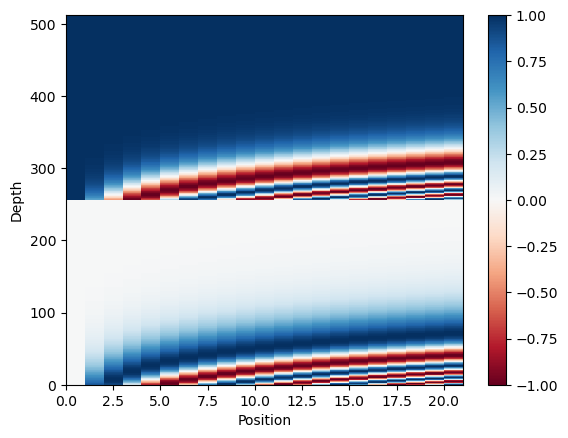

In [24]:
plt.pcolormesh(model.positional_encoding(21,512).numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [25]:
embed_tcr = model.PositionalEmbedding(vocab_size=vocabSize, d_model=512)
embed_ept = model.PositionalEmbedding(vocab_size=vocabSize, d_model=512)

tcr_emb = embed_tcr(tcr)
ept_emb = embed_ept(ept)
# print(tcr_emb._keras_mask)


In [ ]:
sample_encoder = model.Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=vocabSize)

sample_encoder_output = sample_encoder(tcr, training=False)
print(tcr.shape)
print(sample_encoder_output.shape)

(64, 64)
(64, 64, 512)


## model

In [28]:
num_layers = 2
d_model = 256
dff = 512
num_heads = 4
dropout_rate = 0.1

In [29]:
transformer = model.Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=np.int64(vocabSize),
    target_vocab_size=np.int64(vocabSize),
    dropout_rate=dropout_rate)

In [30]:
output = transformer((tcr, ept))

print(tcr.shape)
print(ept.shape)
print(output.shape)

attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 64)
(64, 13)
(64, 13, 23)
(64, 4, 13, 64)


In [31]:
learning_rate = model.CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

# plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
# plt.ylabel('Learning Rate')
# plt.xlabel('Train Step')

In [32]:
transformer.compile(
    loss=model.masked_loss,
    optimizer=optimizer,
    metrics=[model.masked_accuracy])

In [33]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  2637568   
                                                                 
 decoder (Decoder)           multiple                  4742400   
                                                                 
 dense_8 (Dense)             multiple                  5911      
                                                                 
Total params: 7,385,879
Trainable params: 7,385,879
Non-trainable params: 0
_________________________________________________________________


In [54]:
history = transformer.fit(dataset,
                epochs=10,
                validation_data=dataset_val)

Epoch 1/10
18589/18589 [==============================] - 784s 42ms/step - loss: 0.3051 - masked_accuracy: 0.9075 - val_loss: 0.9103 - val_masked_accuracy: 0.8378
Epoch 2/10
18589/18589 [==============================] - 810s 44ms/step - loss: 0.0377 - masked_accuracy: 0.9864 - val_loss: 0.9284 - val_masked_accuracy: 0.8554
Epoch 3/10
18589/18589 [==============================] - 822s 44ms/step - loss: 0.0275 - masked_accuracy: 0.9891 - val_loss: 0.9275 - val_masked_accuracy: 0.8651
Epoch 4/10
 3904/18589 [=====>........................] - ETA: 10:54 - loss: 0.0247 - masked_accuracy: 0.9898

KeyboardInterrupt: 

## Translator

In [383]:
reload(model)

<module 'functions.model' from 'c:\\Users\\croco\\OneDrive - Emory University\\Courses\\BMI 536 Deep Learning\\FinalProj\\functions\\model.py'>

In [55]:
translator = model.Translator(tk_dict, tokens, transformer)

In [56]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [57]:
model.tk2seq(model.seq_pos_coding(sentence,tk_dict, 32),tokens)

NameError: name 'sentence' is not defined

In [58]:
sentence = ("CIVRAPGRADMRF","CASSYLPGQGDHYSNQPQHF")		
ground_truth = "FLKEKGGL"

translated_text, attention_weights = translator(sentence,max_length=14)
print_translation(sentence, translated_text, ground_truth)

Input:         : ('CIVRAPGRADMRF', 'CASSYLPGQGDHYSNQPQHF')
Prediction     : ['>FLKETGGL<<<<<<']
Ground truth   : FLKEKGGL


In [59]:
sentence = ("CAVQAEANNNARLMF","CASSYGGYNEQFF")		
ground_truth = "KLGGALQAK"

translated_text, attention_weights = translator(sentence,max_length=14)
print_translation(sentence, translated_text, ground_truth)

Input:         : ('CAVQAEANNNARLMF', 'CASSYGGYNEQFF')
Prediction     : ['>FTSDYYQLY<<<<<']
Ground truth   : KLGGALQAK


In [60]:
sentence = ("CAASGGGSQGNLIF","CASSTRSQETQYF")#("CAEMEGGSYIPTF","CASSQRPSEVGELFF")		
ground_truth = "GILGFVFTL"#"RAKFKQLL"

translated_text, attention_weights = translator(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : ('CAASGGGSQGNLIF', 'CASSTRSQETQYF')
Prediction     : ['>GILGFVFTL<<<<<']
Ground truth   : GILGFVFTL


In [61]:
tf.saved_model.save(transformer, "models/mdl_vdj_3")
# model = tf.saved_model.load("models/mdl_vdj_1")

INFO:tensorflow:Assets written to: models/mdl_vdj_3\assets


INFO:tensorflow:Assets written to: models/mdl_vdj_3\assets


### plot attention

In [62]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [63]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([14, 64])

In [64]:
in_tokens = model.seq_pos_coding(sentence,tk_dict,32)
in_tokens = tf.convert_to_tensor([tokens[int(i)] for i in in_tokens])
print(in_tokens)
translated_tokens = tf.convert_to_tensor([i for i in translated_text[0]])
print(translated_tokens)

tf.Tensor(
[b'>' b'C' b'A' b'A' b'S' b'G' b'G' b'G' b'S' b'Q' b'G' b'N' b'L' b'I'
 b'F' b'<' b'.' b'.' b'.' b'.' b'.' b'.' b'.' b'.' b'.' b'.' b'.' b'.'
 b'.' b'.' b'.' b'.' b'>' b'C' b'A' b'S' b'S' b'T' b'R' b'S' b'Q' b'E'
 b'T' b'Q' b'Y' b'F' b'<' b'.' b'.' b'.' b'.' b'.' b'.' b'.' b'.' b'.'
 b'.' b'.' b'.' b'.' b'.' b'.' b'.' b'.'], shape=(64,), dtype=string)
tf.Tensor(
[b'>' b'G' b'I' b'L' b'G' b'F' b'V' b'F' b'T' b'L' b'<' b'<' b'<' b'<'
 b'<'], shape=(15,), dtype=string)


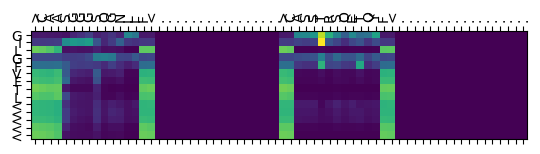

In [65]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [66]:
def plot_attention_weights(in_tokens, translated_tokens, attention_heads):

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

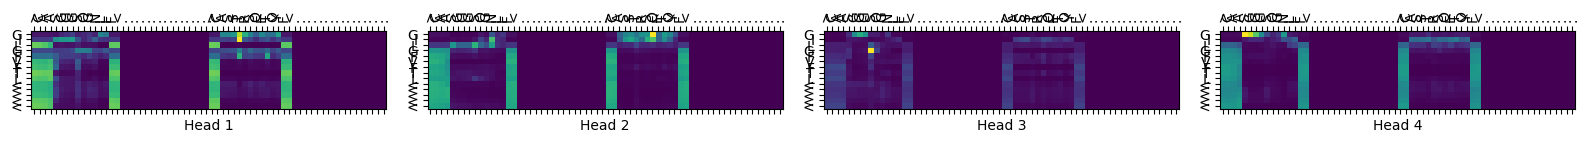

In [67]:
plot_attention_weights(in_tokens,
                       translated_tokens,
                       attention_weights[0])

## export translator

In [459]:
reload(model)
tf.config.run_functions_eagerly(True)

In [68]:
translator = model.ExportTranslator(translator)

In [69]:
tf.saved_model.save(translator, export_dir='models/translator')

INFO:tensorflow:Assets written to: models/translator\assets


INFO:tensorflow:Assets written to: models/translator\assets


In [86]:
dbfile["cdr3.alpha"]

0           CIVRAPGRADMRF
1          CAVPSGAGSYQLTF
2             CAVKASGSRLT
3           CAYRPPGTYKYIF
4           CIVRAPGRADMRF
               ...       
15854    CAFLNAGGTSYGKLTF
15855        CAVYNQGGKLIF
15856      CAVRALYNFNKFYF
15857       CAVESYNTDKLIF
15858    CAMREGQGNAGNMLTF
Name: cdr3.alpha, Length: 15859, dtype: object

In [87]:
scores = []
# dbfile = dbfile.reset_index()
for idx in test.index:
    sentence = (test["cdr3.alpha"][idx],test["cdr3.beta"][idx])		
    ground_truth = test["antigen.epitope"][idx]

    translated_text, _ = translator(sentence,max_length=14)
    scores.append(similarity_point_calculator(translated_text[0],ground_truth))

In [88]:
from scipy import stats
stats.describe(scores)

DescribeResult(nobs=3172, minmax=(-0.4727272727272727, 1.0), mean=0.14538540293099955, variance=0.2469875013651226, skewness=0.9887227307934924, kurtosis=-0.7491140110981354)

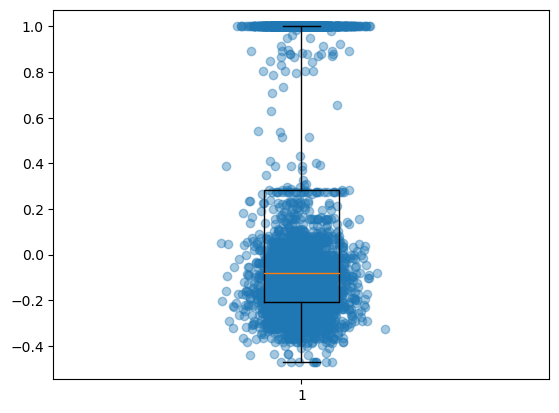

In [89]:
import seaborn as sns
plt.boxplot(scores)
randx = np.random.normal(1, 0.05, len(scores))
plt.scatter(randx, scores, alpha=0.4)
plt.show()

## CV

In [15]:
from sklearn.model_selection import LeaveOneOut,KFold

In [40]:
# ept_db, tcra_db, tcrb_db 
def make_dataset(tcr_db,ept_train,ept_lb_train,n_splits):

    def gen():
        for train_index, test_index in KFold(n_splits).split(ept_db):
            tcr_train, tcr_test = tcr_db[train_index], tcr_db[test_index]
            ept_lb_train, ept_lb_test = ept_db_lb[train_index], ept_db_lb[test_index]
            ept_train, ept_test = ept_db[train_index], ept_db[test_index] 
            yield ((tcr_train,ept_train),ept_lb_train), ((tcr_test,ept_test),ept_lb_test)

    return tf.data.Dataset.from_generator(gen)

dataset=make_dataset(tcr_db,ept_db,ept_db_lb,5)

In [42]:
def new_models():
    transformer = model.Transformer(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        input_vocab_size=np.int64(vocabSize),
        target_vocab_size=np.int64(vocabSize),
        dropout_rate=dropout_rate)
    learning_rate = model.CustomSchedule(d_model)
    optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                    epsilon=1e-9)
    transformer.compile(
        loss=model.masked_loss,
        optimizer=optimizer,
        metrics=[model.masked_accuracy])
    return(transformer)

In [77]:
transformers=[]
histories=[]
trainidx = []
testidx = []
# kfold = KFold(n_splits=5, shuffle=True)
for train_index, test_index in KFold(5,shuffle=True).split(ept_db):
    trainidx.append(train_index)
    testidx.append(testidx)
    tcr_train, tcr_test = tf.gather(tcr_db,indices=train_index), tf.gather(tcr_db,indices=test_index)
    ept_lb_train, ept_lb_test = tf.gather(ept_db_lb,indices=train_index), tf.gather(ept_db_lb,indices=test_index)
    ept_train, ept_test = tf.gather(ept_db,indices=train_index), tf.gather(ept_db,indices=test_index)
    trainset = tf.data.Dataset.from_tensor_slices(((tcr_train,ept_train),ept_lb_train))
    trainset = make_batches(trainset)
    testset = tf.data.Dataset.from_tensor_slices(((tcr_test,ept_test),ept_lb_test))
    testset = make_batches(testset)
    subtransformer = new_models()
    history = subtransformer.fit(trainset,
                epochs=10,
                validation_data=testset)
    histories.append(history)
    transformers.append(subtransformer)
    

Epoch 1/10
199/199 [==============================] - 23s 81ms/step - loss: 2.4808 - masked_accuracy: 0.3037 - val_loss: 1.4977 - val_masked_accuracy: 0.5904
Epoch 2/10
199/199 [==============================] - 15s 74ms/step - loss: 1.2964 - masked_accuracy: 0.6504 - val_loss: 0.9347 - val_masked_accuracy: 0.7516
Epoch 3/10
199/199 [==============================] - 15s 76ms/step - loss: 0.8623 - masked_accuracy: 0.7694 - val_loss: 0.7139 - val_masked_accuracy: 0.8013
Epoch 4/10
199/199 [==============================] - 15s 75ms/step - loss: 0.6834 - masked_accuracy: 0.8099 - val_loss: 0.6206 - val_masked_accuracy: 0.8283
Epoch 5/10
199/199 [==============================] - 15s 76ms/step - loss: 0.6025 - masked_accuracy: 0.8300 - val_loss: 0.5789 - val_masked_accuracy: 0.8340
Epoch 6/10
199/199 [==============================] - 15s 74ms/step - loss: 0.5549 - masked_accuracy: 0.8413 - val_loss: 0.5363 - val_masked_accuracy: 0.8500
Epoch 7/10
199/199 [==============================] 

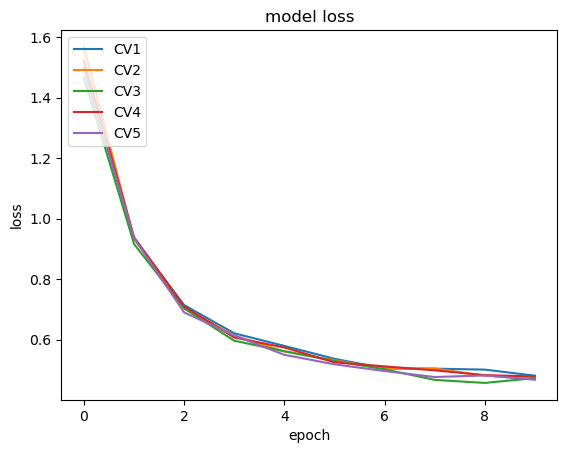

In [78]:
for history in histories:
    plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['CV%d'%(i+1) for i in range(5)], loc='upper left')
plt.show()

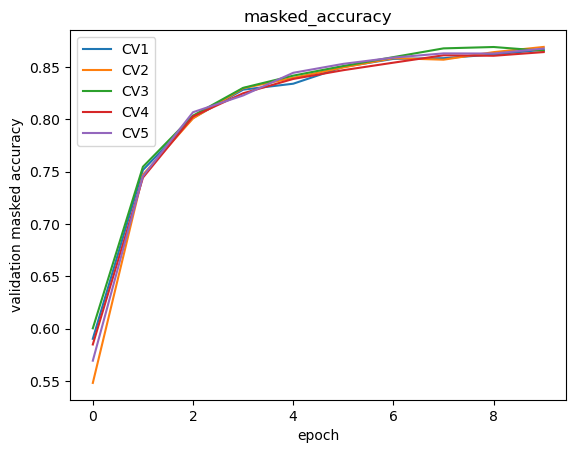

In [79]:
for history in histories:
    plt.plot(history.history['val_masked_accuracy'])
plt.title('masked_accuracy')
plt.ylabel('validation masked accuracy')
plt.xlabel('epoch')
plt.legend(['CV%d'%(i+1) for i in range(5)], loc='upper left')
plt.show()

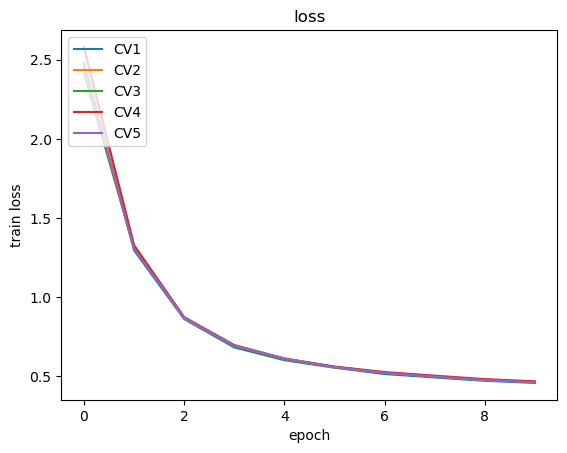

In [82]:
for history in histories:
    plt.plot(history.history['loss'])
plt.title('loss')
plt.ylabel('train loss')
plt.xlabel('epoch')
plt.legend(['CV%d'%(i+1) for i in range(5)], loc='upper left')
plt.show()

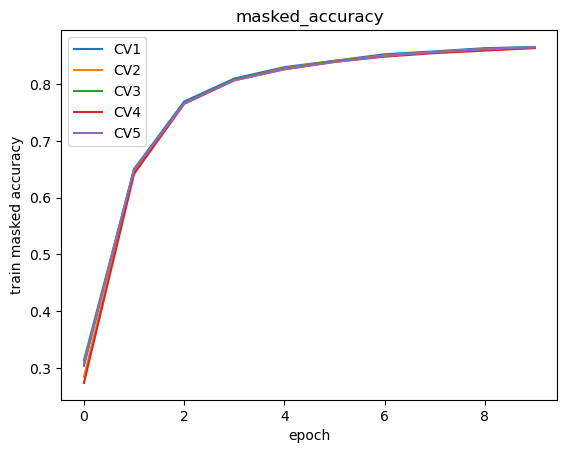

In [83]:
for history in histories:
    plt.plot(history.history['masked_accuracy'])
plt.title('masked_accuracy')
plt.ylabel('train masked accuracy')
plt.xlabel('epoch')
plt.legend(['CV%d'%(i+1) for i in range(5)], loc='upper left')
plt.show()

# load translator and preidtc similarity

In [70]:
def similarity_point_calculator(prediction,ground_truth,blosum50=load.blosum50_20aa):
    blosum50_keys = list(blosum50.keys())
    prediction=prediction.replace(">","").replace("<","").replace(".","")
    similarity_point=0
    max_similarity_point=0
    for i in range(len(ground_truth)):
        true_i=ground_truth[i]
        if i < len(prediction):
            pred_i=prediction[i]
            similarity_point+=blosum50[pred_i][blosum50_keys.index(true_i)]
        max_similarity_point+=blosum50[true_i][blosum50_keys.index(true_i)]
        # print(pred_i,true_i,blosum50[pred_i][blosum50_keys.index(true_i)])
    similarity_ratio=similarity_point/max_similarity_point
    return(similarity_ratio)

In [71]:
dbfile = dbfile.reset_index()
dbfile["cdr3.beta"][10]

'CASSYLPGQGDHYSNQPQHF'

In [72]:
# transformer = transformers[0]
translator = model.Translator(tk_dict, tokens, transformer)
scores = []
# dbfile = dbfile.reset_index()
for idx in test_index:
    sentence = (dbfile["cdr3.alpha"][idx],dbfile["cdr3.beta"][idx])		
    ground_truth = dbfile["antigen.epitope"][idx]

    translated_text, _ = translator(sentence,max_length=14)
    scores.append(similarity_point_calculator(translated_text[0],ground_truth))

NameError: name 'test_index' is not defined

In [86]:
# dbfile['antigen.epitope'], tk_dict, 13,label=True)
# dbfile["cdr3.alpha"]
# dbfile["cdr3.beta"]
# test_index
dbfile["cdr3.alpha"][4]

'CAYRPPGTYKYIF'

In [96]:
from scipy import stats
stats.describe(scores)
import seaborn as sns
plt.boxplot(scores)
randx = np.random.normal(1, 0.05, len(scores))
plt.scatter(randx, scores, alpha=0.4)
plt.show()

DescribeResult(nobs=3171, minmax=(-0.48148148148148145, 1.0), mean=0.1831472229213964, variance=0.26764189931040494, skewness=0.8226172973942975, kurtosis=-1.109487943657555)

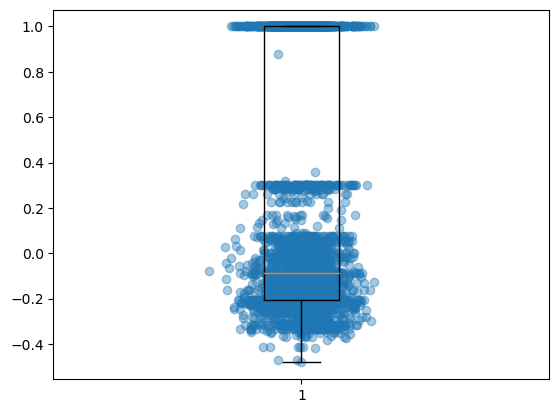

In [105]:
# fig1, ax1 = plt.subplots()
# ax1.set_title('Similarity')
# ax1.boxplot(scores,whis=0.15)
import seaborn as sns

# ax = sns.boxplot(x=scores)
# ax = sns.swarmplot(x=scores)
plt.boxplot(scores)
randx = np.random.normal(1, 0.05, len(scores))

# clevels = np.linspace(0., 1., ngroup)
plt.scatter(randx, scores, alpha=0.4)

plt.show()